In [1]:
%matplotlib nbagg
import functools
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import scipy.integrate as spi
import scipy.optimize as spo
import scipy.interpolate as spolate

In [2]:
def poincaré_map(F, x0s, P, mus, tmax):
    """
    Given a vector field F on R^n, an (m,n) array of m initial
    conditions x0s, a function P which changes sign when the
    trajectory crosses the Poincaré section, and an optional vector
    mu of bifurcation parameter values, computes the Poincaré map
    for each initial condition in x0s. Evaluation attempts time out
    at t = tmax.

    Returns both the Poincaré map evaluations and the array of times
    taken to reach those points.
    """

    P.terminal = True
    mus = np.asarray(mus)
    x0s = np.asarray(x0s)

    Tret = np.zeros((mus.shape[0], x0s.shape[0]))
    Xpcr = np.zeros((mus.shape[0],) + x0s.shape)

    for i, mu in enumerate(mus):
        fun = functools.partial(F, mu)
        for j, x0 in enumerate(x0s):
            out = spi.solve_ivp(fun, (0,tmax), x0, events=P)
            if out.status == 1:
                Tret[i,j] = out.t[-1]
            else:
                Tret[i,j] = np.inf
            Xpcr[i,j,:] = out.y[:,-1]

    return Tret, Xpcr


def plot_one_poincaré(u0s, Upcr):

    plt.plot(u0s, Upcr)
    plt.plot(u0s, u0s, 'k:')
    plt.title('Poincaré map')
    plt.xlabel('$u$')
    plt.xlabel('$u^+$')


def poincaré_bifurcation(mus, u0s, Tret, Upcr):
    Upcr = ma.masked_array(Upcr - u0s, mask=~np.isfinite(Tret))

    plt.contour(mus, u0s, Upcr.T, levels=[0])
    plt.xlabel('Bifurcation parameter $\mu$')
    plt.ylabel('Fixed point $u^*$')


In [4]:
# Parameters for cortical RS pyramidal neuron taken from Izhikevich (2003)
C, k = 100, 0.7
vr, vt, vp = -60, -40, 35
a, b, c, d = 0.03, -2, -50, 100

Istar = k/4 * (vr - vt - b/k)**2

def jump_map(vu):
    return np.array([c,d]) + np.array([0,1]) * vu

def flow_map(I, t, vu):
    v, u = vu
    vdot = (k*(v - vr)*(v - vt) - u + I)/C
    udot = a * (b * (v - vr) - u)
    return np.array([vdot, udot])

def P(t, vu):
    return vu[0] - vp

tmax = 10000
u0s = np.linspace(-100, 500, num=51)
mus = np.geomspace(1, 1000, num=101)
x0s = jump_map(np.array([vp + 0*u0s, u0s]).T)

Tret, Xpcr = poincaré_map(flow_map, x0s, P, mus, tmax=tmax)


<IPython.core.display.Javascript object>


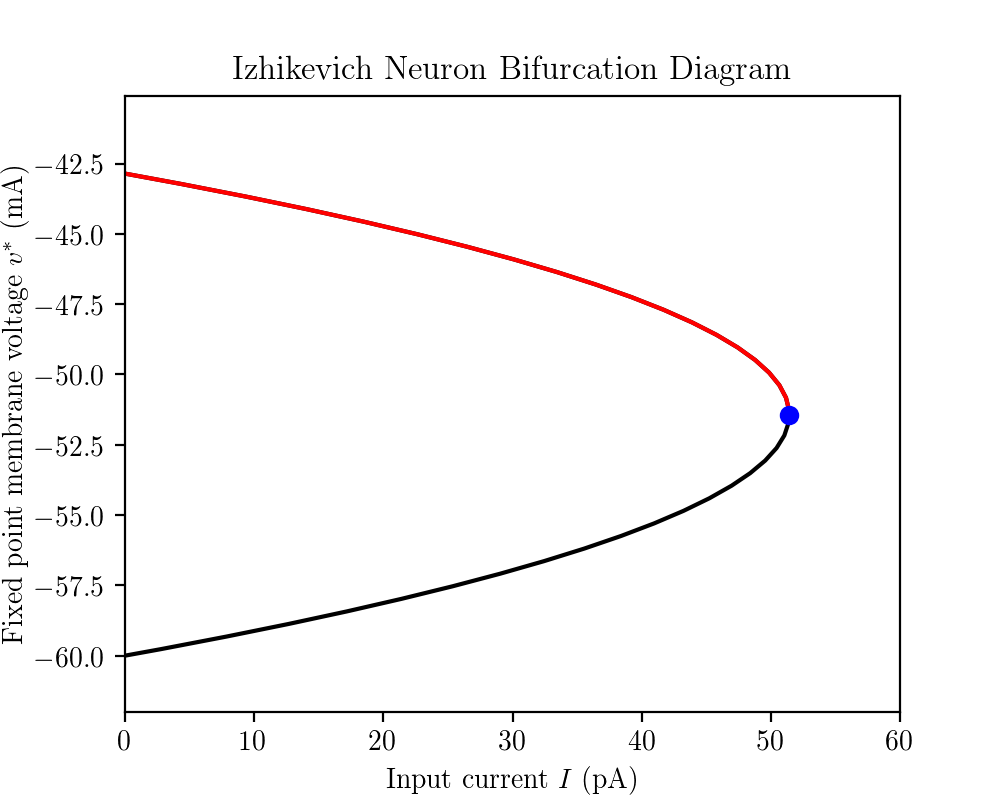

In [5]:
def bifurcation_diagram(f, fx, x, mu):
    "Plot a bifurcation diagram of a 1D dynamical system."
    xx = x.reshape((-1,1))
    mumu = mu.reshape((1,-1))
    fvals = f(xx, mumu)
    fxvals = fx(xx, mumu)
    fvalsP = np.ma.masked_where(fxvals<0, fvals)
    plt.contour(mu, x, fvals, levels=[0], colors='k')
    plt.contour(mu, x, fvalsP, levels=[0], colors='r')
    plt.xlabel('$\mu^*$')
    plt.ylabel('$x^*$')


# Restriction of the system to the u nullcline.
def f(v,I):
    return (k*(v - vr)*(v - vt - b/k) + I)/C

# 1D system derivative wrt v
def fv(v,I):
    return k/C * (2*v - vr - vt - b/k) + 0*I

plt.figure(figsize=(5,4))
bifurcation_diagram(f, fv, np.linspace(-62, -40.1), np.linspace(0,60))
plt.plot(k*(vr - vt - b/k)**2 / 4, (vr + vt + b/k)/2, 'bo')
plt.xlabel('Input current $I$ (pA)')
plt.ylabel('Fixed point membrane voltage $v^*$ (mA)', labelpad=2)
plt.title('Izhikevich Neuron Bifurcation Diagram')
plt.savefig('saddlenode.png', dpi=300)

In [6]:
# Find the fixed points and return times of the Poincaré map.
ustars = np.zeros_like(mus)
tstars = np.zeros_like(mus)

Upcr = Xpcr[:,:,1]
guesses = np.argmin(np.abs(Upcr - u0s), axis=1)

mupoints = np.tile(mus.reshape((-1,1)), (1,len(u0s)))[np.isfinite(Tret)]
u0points = np.tile(u0s.reshape((1,-1)), (len(mus),1))[np.isfinite(Tret)]
uvals = Upcr[np.isfinite(Tret)]
Pinterp = spolate.SmoothBivariateSpline(mupoints, u0points, uvals)

for i,mu in enumerate(mus):
    ustars[i] = spo.fixed_point(lambda u: Pinterp(mu, u), guesses[i])
    
    x0 = jump_map(np.array([[vp, ustars[i]]]))
    tstars[i] = poincaré_map(flow_map, x0, P, [mu], tmax=tmax)[0]

In [17]:
# Find closest linear fit to frequency, i.e. 1/I fit to period.
finites = np.isfinite(tstars)
if np.any(finites):
    alpha = np.poly1d(np.polyfit(mus[mus > 200], 1/tstars[mus > 200], deg=1))
else:
    alpha = lambda mus: mus*0


In [19]:
# Find a fit of the form a*r(I - I0)^k.
I0 = 51.4
def squirt(params, mus):
    a, k = params
    out = np.zeros_like(mus)
    out[mus >= I0] = a * (mus[mus >= I0] - I0)**k
    return out

params = spo.fmin(lambda params: np.sum((squirt(params, mus[mus > 200]) - 1/tstars[mus > 200])**2), 
                           np.array([1e-4, 0.8]))
# squirt = functools.partial(squirt, params)
print(params)

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 81
         Function evaluations: 151
[0.00084765 0.75248734]


<IPython.core.display.Javascript object>


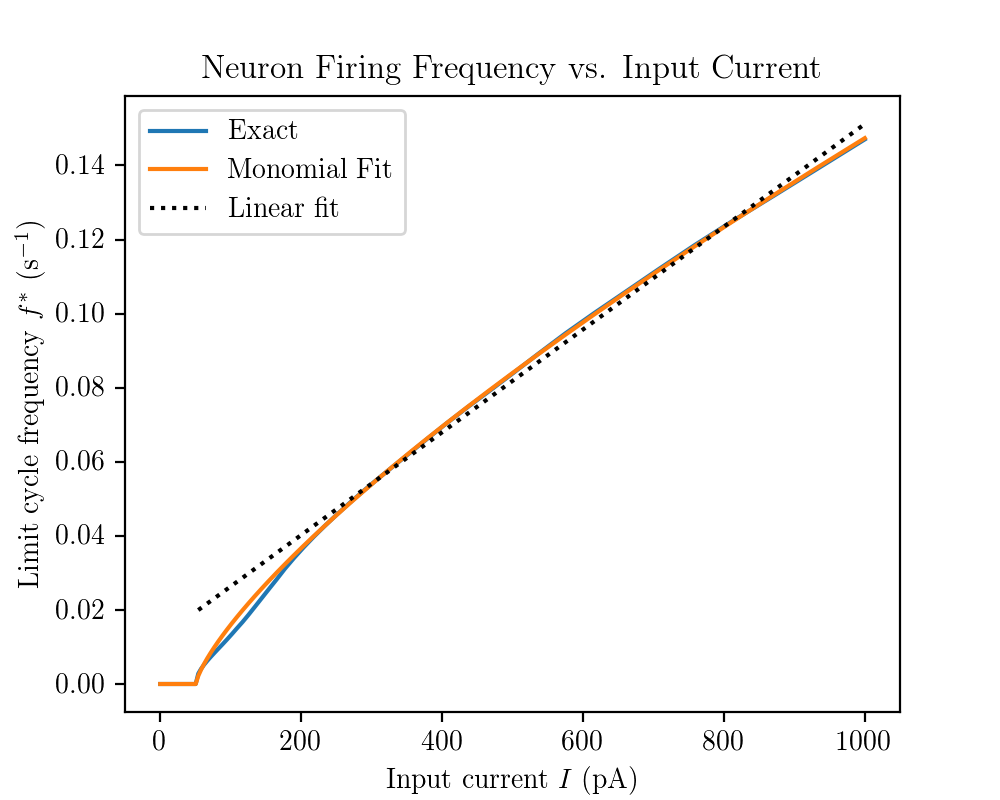

In [21]:
plt.figure(figsize=(5,4))
plt.plot(mus, 1/tstars, label='Exact')
plt.plot(mus, squirt(params, mus), label='Monomial Fit')
# plt.plot(mus, squirt(params, mus), linewidth=1, label='$(I-I^*)^{3/4}$')
plt.plot(mus[finites], alpha(mus[finites]), 'k:', label='Linear fit')
plt.legend()
plt.xlabel('Input current $I$ (pA)')
plt.ylabel('Limit cycle frequency $f^*$ (s$^{-1}$)')
plt.title('Neuron Firing Frequency vs. Input Current')
xlim = plt.xlim()
# plt.savefig('frequency.png', dpi=300)

<IPython.core.display.Javascript object>


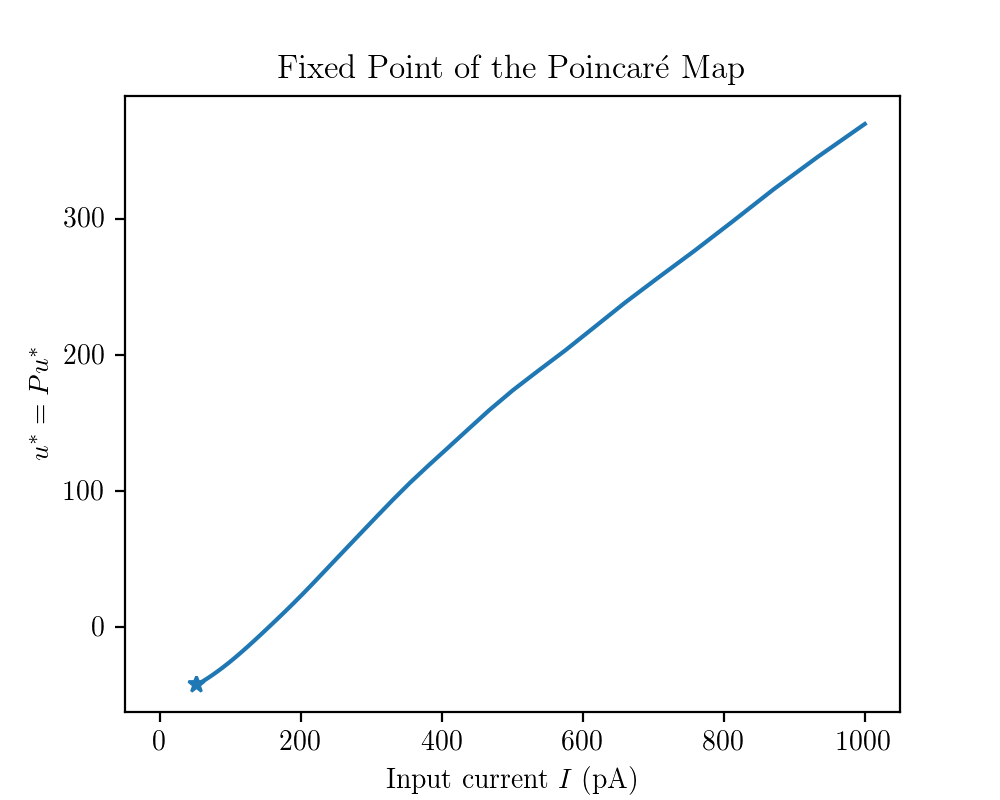

54.954087385762456

In [12]:
plt.figure(figsize=(5,4))
plt.plot(mus[finites], ustars[finites])
plt.plot(Istar, ustars[finites][0], '*', color='tab:blue')
plt.xlabel('Input current $I$ (pA)')
plt.ylabel('$u^* = Pu^*$')
plt.title('Fixed Point of the Poincar\\\'e Map')
plt.xlim(xlim) # Copy bounds from the above figure for more consistency
# plt.savefig('bifurcation.png', dpi=300)

In [13]:
# Simulate a hybrid system like this one.
# Returns a hybrid time domain, see Goebel et al (2009).
def hybrid_sim(flow_map, jump_map, jump_set, t_range, x0):
    jump_set.terminal = True
    
    xouts = []
    touts = []
    
    i = 0
    jumps = 0
    while True:
        # Compute and save the results until an event or the end.
        res = spi.solve_ivp(flow_map, t_range, x0, events=jump_set)
        
        di = len(res.t)
        xouts.append(res.y)
        thist = np.vstack((res.t, np.zeros_like(res.t) + jumps))
        touts.append(thist)
        
        # Done because of failure or finishing.
        if res.status==0 or res.status==-1:
            break
        
        # Not done, so a jump occurred.
        jumps += 1
        x0 = jump_map(res.y[:,-1])
        t_range = res.t[-1], t_range[1]
    
    touts = np.hstack(touts)
    xouts = np.hstack(xouts)
    return touts, xouts.T

Itest = 60#pA
x0 = np.array([(vr + vt)/2, 0])
tout, xout = hybrid_sim(functools.partial(flow_map, Itest), jump_map, P, (0,1000), x0)

<IPython.core.display.Javascript object>


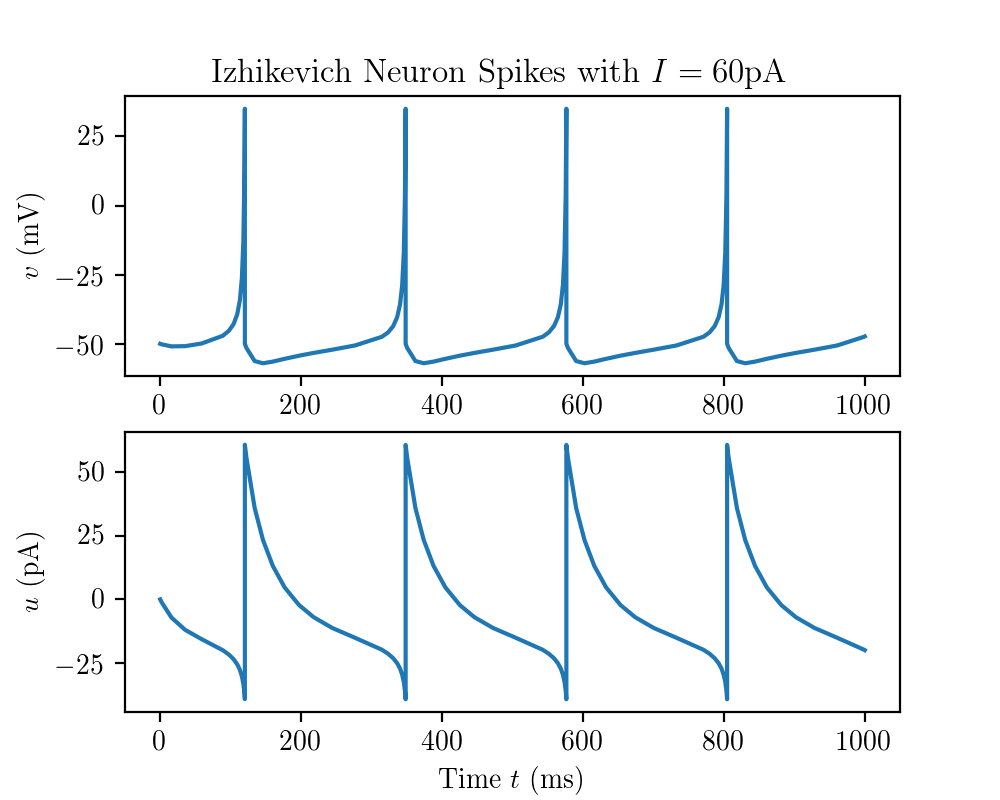

In [28]:
plt.figure(figsize=(5,4))

plt.subplot(211)
plt.plot(tout[0,:], xout[:,0])
plt.ylabel('$v$ (mV)')
plt.subplot(212)
plt.plot(tout[0,:], xout[:,1])
plt.ylabel('$u$ (pA)')

plt.xlabel('Time $t$ (ms)')
plt.suptitle('Izhikevich Neuron Spikes with $I = {}\\mathrm{{pA}}$'.format(Itest), y=0.925)
plt.savefig('vmemdemo.png', dpi=300)

# Bibliography

Izhikevich, E. M. (2007). Dynamical systems in neuroscience. MIT press.
> This book is the best source of the computationally
> efficient neuron model I used (albeit not with as much
> physical explanation as I attempted to provide, but at
> least the units check out now), with demonstrations
> of how to tune the parameters to reproduce the behavior
> of actual cell types measured in vivo, as well as
> dynamical systems analyses of the resulting models.
> It's also a pretty good introduction to bifurcation theory!

R. Goebel, R. G. Sanfelice, and A.R. Teel (2009). "Hybrid dynamical systems", IEEE Control Systems Magazine, vol. 29, no. 2, pp. 28-93.
> This paper introduce hybrid dynamical systems, in particular
> how to rigorously define time for them on $\mathbb{N}\times\mathbb{R}$
> and how to find limit cycles using a Poincaré map.